# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Voronoi's reduction, in dimension 6

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('TensorVoronoi','Algo')

In [2]:
from agd import LinearParallel as lp
from agd.Selling import GatherByOffset
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorVoronoi'

The routines for tensor decomposition are for efficiency purposes provided in a small c++ library, named FileVDQ where VDQ stands for "Voronoi Decomposition of Quadratic forms". This is in contrast with the two and three dimensional cases, where the decomposition algorithm is coded in Python (the c++ library can also be used in smaller dimensions). A function named `VoronoiDecomposition` provides the interface.

In [3]:
from agd.Eikonal import VoronoiDecomposition

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 0.1 Optional configuration

Uncomment the following line to use the GPU implementation of Voronoi's decomposition.

In [5]:
VoronoiDecomposition.default_mode = 'gpu_transfer'

## 1. Computing the decomposition of a tensor

We illustrate our tensor decomposition method on random positive definite matrices, of the form 
$$
    D = A^T A,
$$
where $A$ is a square matrix with random coefficients w.r.t. the Gaussian normal law.

In [6]:
def MakeRandomTensor(dim,shape = tuple()):
    A = np.random.standard_normal( (dim,dim) + shape )
    return lp.dot_AA(lp.transpose(A),A)

In [7]:
# For reproducibility, we fix the random seed
np.random.seed(42) 

The inserse operation to tensor decomposition is, of course, reconstruction, defined by 
$$
    (\lambda_i, e_i)_{i=1}^I \mapsto D = \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T
$$

In [8]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)

In [9]:
def LInfNorm(a):
    return np.max(np.abs(a))

### 1.1 Case of a  $4 \times 4$ tensor

In [10]:
D4 = MakeRandomTensor(4)

In [11]:
coefs,offsets = VoronoiDecomposition(D4)

Our decomposition, of a $4 \times 4$ SPD tensor, involves either $10$ or $12$ coefficients and offsets. 
If the tensor is randomly generated, then each possibility arises with positive probability, in approximately half the cases.

For uniformity of the data structures, we always return $12$ coefficients and offsets, but the last two are often zero.

In [12]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.00623791 1.739663   0.30215493 0.27498621 0.18107025 0.0664281
 0.00623789 1.3873893  0.93488663 0.16328326 0.0062379  0.15724699]
Offsets : 
 [[ 1  0  0  0  1  1  0  0  0  1  1  1]
 [ 0  1  1  0 -1 -1  1  0  1 -1 -1 -2]
 [ 1  0  1 -1  0  1  1 -1  2 -1  0 -1]
 [ 2  0  1  0  1  2  0 -1  1  1  2  1]]


By design, the coefficients are non-negative, and the reconstruction is exact up to numerical precision.

In [13]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D4-Reconstruct(coefs,offsets)))
assert np.allclose(D4,Reconstruct(coefs,offsets))

Minimal coefficient :  0.006237894296646118
Reconstruction error :  5.549733129717183e-07


### 1.1 Case of a  $6 \times 6$ tensor

In [24]:
D = MakeRandomTensor(5)

In [33]:
coefs,offsets = VoronoiDecomposition(D)

Our decomposition, of a $4 \times 4$ SPD tensor, involves either $10$ or $12$ coefficients and offsets. 
If the tensor is randomly generated, then each possibility arises with positive probability, in approximately half the cases.

For uniformity of the data structures, we always return $12$ coefficients and offsets, but the last two are often zero.

In [25]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.0040075  0.01380809 0.01621839 0.03837898 0.0451208  0.10461955
 0.10873732 0.14123254 0.14496666 0.15224508 0.43331082 0.49786014
 0.53529764 0.53603603 0.63898989 0.78572683 0.87795904 0.88744614
 1.27269629 1.99653507 2.08744544]
Offsets : 
 [[-1  1  0  1 -2 -1  2 -1  0  0  1  0  0  1  0 -1 -1  0  0  0  0]
 [-2 -1  0  0 -1 -1  0 -1 -1  0 -1 -1  0  0 -1  0 -1 -1  0  0 -1]
 [ 0 -1  0 -1  1  0 -1  0  0  0 -1  0  0 -1  0  1  0  0  0  0  0]
 [-2 -2 -1 -1  0  0 -1 -1 -2  0 -1 -1 -1 -1 -1  0 -1  0  0 -1 -1]
 [ 2  1  1  1  0  1  1  1  1 -1  2  0 -1  0  2  0  0  1  1  0  1]
 [ 0  0 -1 -1  0  0  0 -1  0  0  0  1  0  0  0  0  0  1 -1  0  0]]


By design, the coefficients are non-negative, and the reconstruction is exact up to numerical precision.

In [26]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D6-Reconstruct(coefs,offsets)))
assert np.allclose(D6,Reconstruct(coefs,offsets))

Minimal coefficient :  0.004007495005622951
Reconstruction error :  1.6708856520608606e-14


## 1.2 A family of tensors

In [27]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(np.array([(1-t)*a + t*b for t in T]),0,-1)

In [33]:
T_interp, D_interp = Interpolate(MakeRandomTensor(6),MakeRandomTensor(6))

In [41]:
coefs,offsets = VoronoiDecomposition(D_interp)

In [37]:
print("Reconstruction error : ", LInfNorm(D_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D_interp, Reconstruct(coefs,offsets),atol=1e-5)

Reconstruction error :  9.947598300641403e-14


In [38]:
decomp = GatherByOffset(T_interp,coefs,offsets)

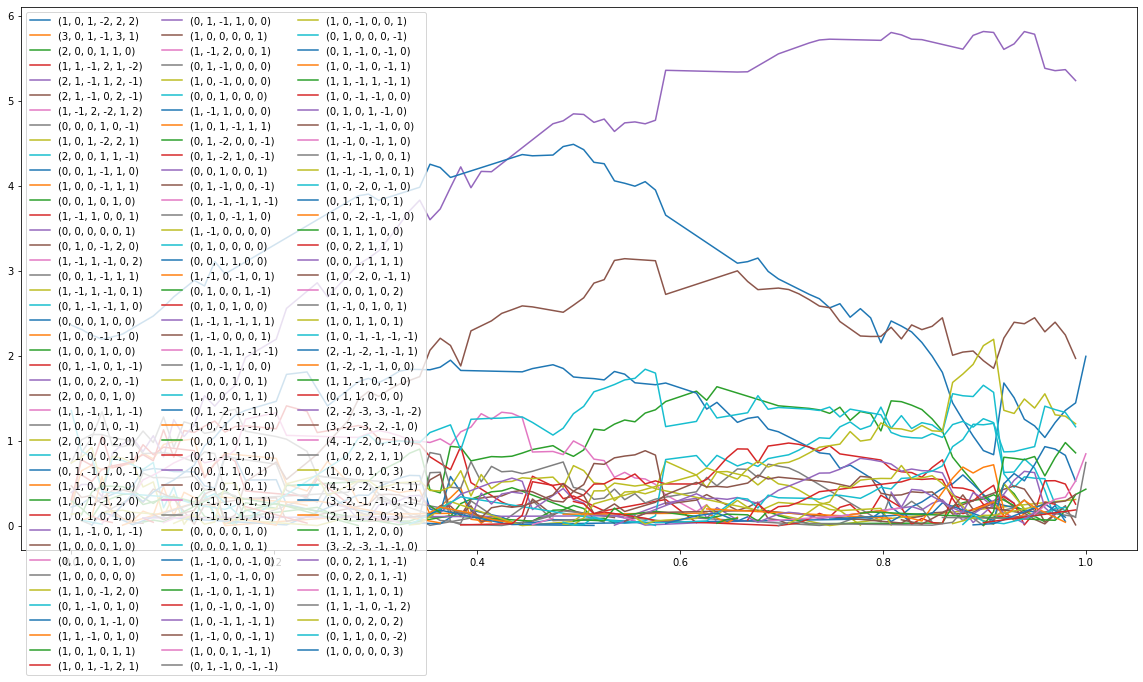

In [39]:
fig = plt.figure(figsize=(20,10))
for offset,(time,coef) in decomp.items():
    plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Vor4.pdf")

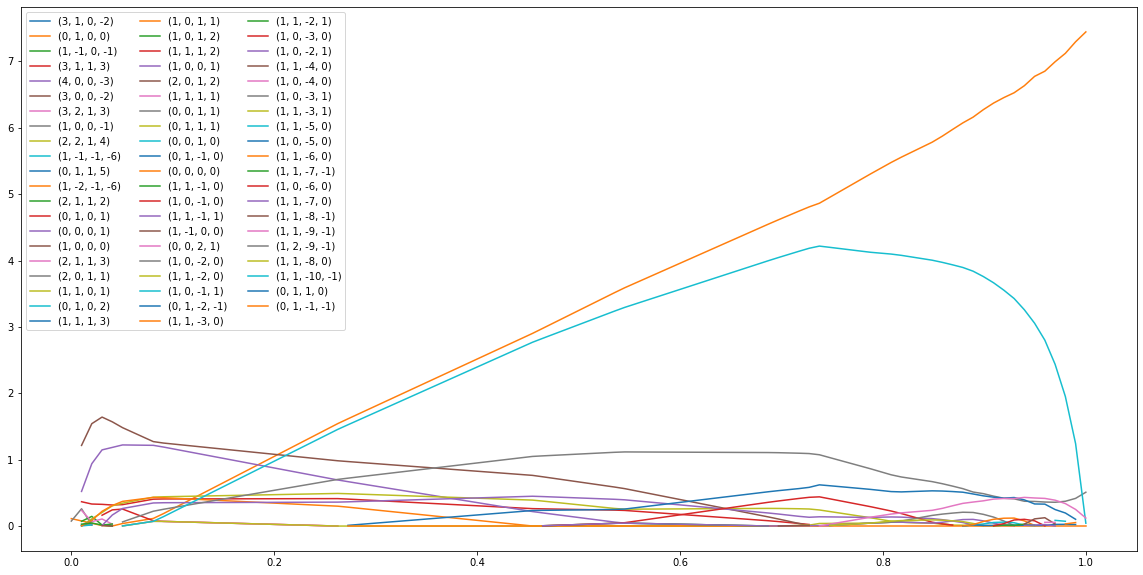

In [32]:
fig = plt.figure(figsize=(20,10))
for offset,(time,coef) in decomp.items():
    plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Vor4.pdf")